# Center of Pressure Computation

In [52]:
using LinearAlgebra
using PyCall
using PyPlot
include("../scripts/AerodynamicsModel.jl")
include("../scripts/Params.jl")
include("../scripts/SphereConeVehicleModel.jl")

entry_vehicle_simplified_dynamics (generic function with 1 method)

## Saving coefficients

In [70]:
params = Dict("r_min" => 0.001, # smallest radius of the cone [m]
              "r_max" => 1.30, # largest radius of the cone [m]
              "δ" => 45 / 360 * 2 * pi, # opening angle of the cone [rad]
              "m" => 569.7, # mass of the Phoenix entry system [kg]
              "x_g" => -0.150, # axial center-of-gravity location [m]
              "c" => 1.20, # distance between the radial axis and the cluster of thrusters[m]
              "F_max" => 36.0, # maximum force applied by the thrusters [N]
              "Jxx" => 293.15, # Phoenix entry system [kg.m^2]
              "Jyy" => 184, # Phoenix entry system [kg.m^2]
              "Jzz" => 208.02, # Phoenix entry system [kg.m^2]
              "Jxy" => 0.451, # Phoenix entry system [kg.m^2]
              "Jxz" => -4.424, # Phoenix entry system [kg.m^2] 
              "Jyz" => 0.372, # Phoenix entry system [kg.m^2]
              "g" => 3.711, # Mars gravity [m^2.s^-1]
              "h" => 10800, # Atmospheric Scale Height [m]
              "ρ_0" => 0.020, # Surface density of Mars atmosphere [kg.m^-3]
              "r_p" => 3389.5e3, # Volumetric mean radius of Mars [m]
              "ω_p" => [0, 0, 7.088e-05]) # Angular velocity of Mars [rad.s^-1]
complete_params!(params);

## Dynamics model

In [71]:
function open_loop_entry_vehicle_simplified_dynamics(X::Vector)
    u = zeros(4,1)
    ẋ = X - X
    entry_vehicle_simplified_dynamics!(ẋ, X, u, params)
end

open_loop_entry_vehicle_simplified_dynamics (generic function with 1 method)

## Initial State

In [72]:
# Iniitial altitude
x_0 = - 125000.0 - 3389.5e3

# Initial speed
v_0 = 5500 * [1, 0, 0]

# Initial orientation
q_0 = [1, 0, 0, 0]
q_0 = [0.999, 0, 0, 0.04]
q_0 = q_0 / norm(q_0)
    
# Initial state
X_0 = [x_0, 0, 0, q_0[1], q_0[2], q_0[3], q_0[4], v_0[1], v_0[2], v_0[3], 0, 0, 0]

13-element Array{Float64,1}:
   -3.5145e6            
    0.0                 
    0.0                 
    0.999199360160512   
    0.0                 
    0.0                 
    0.040007982388809295
 5500.0                 
    0.0                 
    0.0                 
    0.0                 
    0.0                 
    0.0                 

## Plot Force Angles

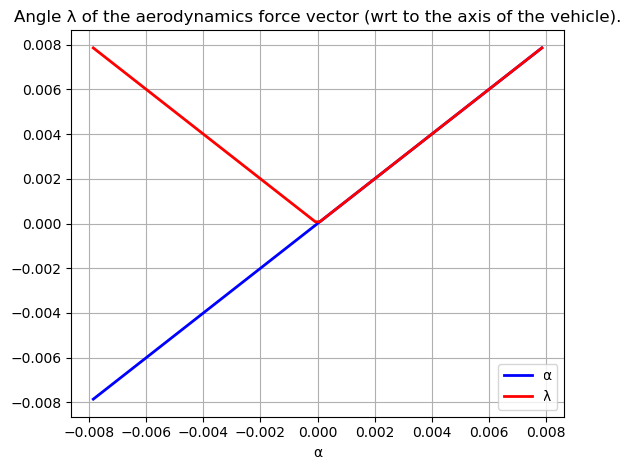

In [73]:
function plot_force_angles(params, num_nodes; display=true)
    r_max = params["r_max"]
    r_min = params["r_min"]
    l = params["l"]
    x_g = params["x_g"]

    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)

    α = range(-0.01δ, stop=0.01δ, length=num_nodes)
    V_inf = zeros(length(α), 3)
    P = zeros(length(α), 3)
    F_a = zeros(length(α), 3)
    τ_a = zeros(length(α), 3)
    for i=1:length(α)
        V_inf[i, :] = [-cos(α[i]), sin(α[i]), 0]
        F_hat = params["F_hat"]
        τ_hat = params["τ_hat"]
        F_a[i, :], τ_a[i, :] = illuminated_aerodynamics_online(F_hat, τ_hat, 1.0, V_inf[i, :])
    end
    λ = zeros(num_nodes)
    for i=1:num_nodes
        λ[i] = atan(sqrt(F_a[i, 2]^2 + F_a[i, 3]^2) / -F_a[i, 1])
    end

    plot(α, α, color="blue", linewidth=2.0, linestyle="-", label="α")
    plot(α, λ, color="red", linewidth=2.0, linestyle="-", label="λ")
    legend()
    xlabel("α")
    title("Angle λ of the aerodynamics force vector (wrt to the axis of the vehicle).")
    grid("on")
    if display 
        tight_layout()
        show()
    end
    return
end
num_nodes = 100
plot_force_angles(params, num_nodes)

# Center of pressure

In [62]:
function center_of_pressure(r_max, r_min, l, x_g, V_inf)
    # Geometry of the vehicle
    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)
    OC = [0, 0, 0] 
    OS = [f - r_0, 0, 0] 
    
    P_c, F_c = cone_pressure_integrals(r_max, r_min, l, x_g, V_inf)
    P_s, F_s = sphere_pressure_integrals(r_max, r_min, l, x_g, V_inf)
    P = P_c / (F_c + F_s) + P_s / (F_c + F_s)
    return P + [x_g, 0, 0]
end

function cone_pressure_integrals(r_max, r_min, l, x_g, V_inf)
    # define domain of integration and number of evaluation in the integral computation.
    start_bound = [r_min, 0.0]
    end_bound = [r_max, 2 * pi]
    # Define both integrands with fixed parameters r_d and α.
    function cone_center_pressure_integrand(x::SVector{2,Float64})
        return cone_center_pressure_integrand_parameterized(x, r_max, r_min, l, V_inf, x_g)
    end
    function cone_pressure_integrand(x::SVector{2,Float64})
        return cone_pressure_integrand_parameterized(x, r_max, r_min, l, V_inf, x_g)
    end
    # Parameters of integration to limit memory usage and running time.
    rtol = 1e-4
    maxevals = 1000
    # Integration
    P_c, _ = hcubature(cone_center_pressure_integrand, start_bound, end_bound;
        norm=norm, rtol=rtol, maxevals=maxevals)
    F_c, _ = hcubature(cone_pressure_integrand, start_bound, end_bound;
        norm=norm, rtol=rtol, maxevals=maxevals)
    return P_c, F_c
end

function sphere_pressure_integrals(r_max, r_min, l, x_g, V_inf)
    # Geometry of the vehicle
    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)

    # define domain of integration and number of evaluation in the integral computation.
    start_bound = [r_0, 0.0]
    end_bound = [r_d, 2 * pi]
    # Define both integrands with fixed parameters r_d and α.
    function sphere_center_pressure_integrand(x::SVector{2,Float64})
        return sphere_center_pressure_integrand_parameterized(x, r_max, r_min, l, V_inf, x_g)
    end
    function sphere_pressure_integrand(x::SVector{2,Float64})
        return sphere_pressure_integrand_parameterized(x, r_max, r_min, l, V_inf, x_g)
    end
    # Parameters of integration to limit memory usage and running time.
    rtol = 1e-4
    maxevals = 1000
    # Integration
    P_s, _ = hcubature(sphere_center_pressure_integrand, start_bound, end_bound;
        norm=norm, rtol=rtol, maxevals=maxevals)
    F_s, _ = hcubature(sphere_pressure_integrand, start_bound, end_bound;
        norm=norm, rtol=rtol, maxevals=maxevals)
    return P_s, F_s
end

function cone_center_pressure_integrand_parameterized(x::SVector{2,Float64}, r_max, r_min, l, V_inf, x_g)
    u = x[1]
    v = x[2]
    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)
    
    du = [- 1/tan(δ), cos(v), -sin(v)]
    dv = [0, -u*sin(v), -u*cos(v)]
    r = [l - u/tan(δ), u*cos(v), -u*sin(v)] + [-x_g, 0, 0] 
    ds = norm(cross(du, dv))
    n = cross(du, dv) / ds
    y = r * (V_inf' * n)^2 * (n' * cross(du, dv))
    
#     println("center pressure cone ", y)
#     println("r center pressure cone ", r)
    return y
end

function cone_pressure_integrand_parameterized(x::SVector{2,Float64}, r_max, r_min, l, V_inf, x_g)
    u = x[1]
    v = x[2]
    # angle of the cone
    δ = atan(r_max, l)
    du = [- 1/tan(δ), cos(v), -sin(v)]
    dv = [0, -u*sin(v), -u*cos(v)]
    ds = norm(cross(du, dv))
    n = cross(du, dv) / ds
    y = (V_inf' * n)^2 * (n' * cross(du, dv))
#     println("pressure cone ", y)
    return y
end

function sphere_center_pressure_integrand_parameterized(x::SVector{2,Float64}, r_max, r_min, l, V_inf, x_g)
    u = x[1]
    v = x[2]
    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)
    
    du = [1, -u*cos(v)/sqrt(r_d^2 - u^2), -u*sin(v)/sqrt(r_d^2 - u^2)]
    dv = [0, -sqrt(r_d^2 - u^2)*sin(v), sqrt(r_d^2 - u^2)*cos(v)]
    r = [u, sqrt(r_d^2 - u^2)*cos(v), sqrt(r_d^2 - u^2)*sin(v)] + [f - r_0, 0, 0] + [-x_g, 0, 0]
    
    ds = norm(cross(du, dv))
    n = cross(du, dv) / ds
    y = r * (V_inf' * n)^2 * (n' * cross(du, dv))
    return y
end

function sphere_pressure_integrand_parameterized(x::SVector{2,Float64}, r_max, r_min, l, V_inf, x_g)
    u = x[1]
    v = x[2]
    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)
    
    du = [1, -u*cos(v)/sqrt(r_d^2 - u^2), -u*sin(v)/sqrt(r_d^2 - u^2)]
    dv = [0, -sqrt(r_d^2 - u^2)*sin(v), sqrt(r_d^2 - u^2)*cos(v)]
    ds = norm(cross(du, dv))
    n = cross(du, dv) / ds
    y = (V_inf' * n)^2 * (n' * cross(du, dv))
    return y
end

sphere_pressure_integrand_parameterized (generic function with 1 method)

In [80]:
function plot_center_of_pressure(params, num_nodes; display=true)
    r_max = params["r_max"]
    r_min = params["r_min"]
    l = params["l"]
    x_g = params["x_g"]

    # angle of the cone
    δ = atan(r_max, l)
    # radius of the sphere
    r_d = r_min / cos(δ)
    # distance between the center of the sphere and the base of the small cone
    r_0 = sqrt(r_d^2 - r_min^2)
    # length of the section of cone.
    f = l * (1 - r_min/r_max)

    α = range(-δ, stop=δ, length=num_nodes)
    u = range(r_min, stop=r_max, length=num_nodes)
    w = range(r_0, stop=r_d, length=num_nodes)
    V_inf = zeros(length(α), 3)
    P = zeros(length(α), 3)
    cone_up = zeros(length(α), 3)
    cone_down = zeros(length(α), 3)
    sphere_up = zeros(length(α), 3)
    sphere_down = zeros(length(α), 3)
    for i=1:length(α)
        V_inf[i, :] = [-cos(α[i]), -sin(α[i]), 0]
        P[i, :] = center_of_pressure(r_max, r_min, l, x_g, V_inf[i, :])
        cone_up[i, :] = [l - u[i] / tan(δ), u[i], 0]
        cone_down[i, :] = [l - u[i] / tan(δ), -u[i], 0]
        sphere_up[i, :] = [f - r_0 + w[i], sqrt(r_d^2 - w[i]^2), 0]
        sphere_down[i, :] = [f - r_0 + w[i], -sqrt(r_d^2 - w[i]^2), 0]
    end
    plot(P[:, 1], P[:, 2], color="blue", linewidth=2.0, linestyle="-", label="Center of Pressure")
    plot(cone_up[:, 1], cone_up[:, 2], color="red", linewidth=2.0, linestyle="-", label="Vehicle")
    plot(cone_down[:, 1], cone_down[:, 2], color="red", linewidth=2.0, linestyle="-", label="Vehicle")
    plot(sphere_up[:, 1], sphere_up[:, 2], color="red", linewidth=2.0, linestyle="-", label="Vehicle")
    plot(sphere_down[:, 1], sphere_down[:, 2], color="red", linewidth=2.0, linestyle="-", label="Vehicle")
    scatter(x_g, 0, color="green", marker="+", label="Center of Mass")
    legend()
    xlabel("x")
    ylabel("y")
    title("Center of Pressure of the vehicle vehicle.")
    grid("on")
    axis("equal")
    if display 
        tight_layout()
        show()
    end
    return
end


plot_center_of_pressure (generic function with 1 method)

## We plot the center of pressure with the center of mass at the origin of the frame.

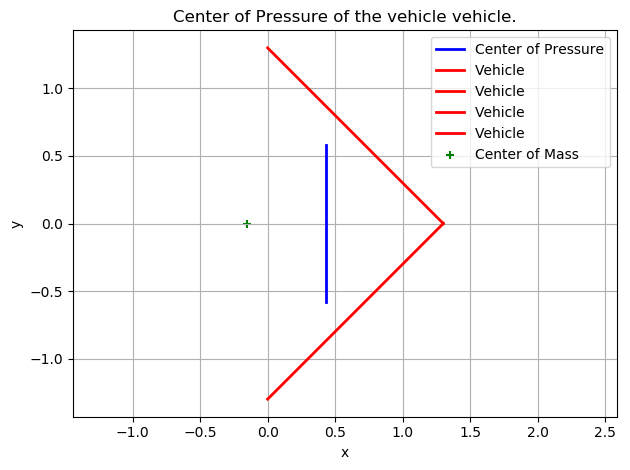

In [81]:
num_nodes = 100
plot_center_of_pressure(params, num_nodes)